In [1]:
import matplotlib.pyplot as plt
import numpy as np

"""In order to provide a better presentation of the graphs we use the rcParams options shown below."""

import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

In [2]:
"""Our system of differential equations belongs to the complex space, that is why we implemented the code suggested in"""
"""https://stackoverflow.com/questions/19910189/scipy-odeint-with-complex-initial-values."""

import time
import numpy as np
from scipy.integrate import odeint
from scipy.special import zeta

def odeintz(func, z0, t, **kwargs):
   
    
    """An odeint-like function for complex valued differential equations.

    Inputs:
    ----------
      -func: function associated to dr/dt=f(x;t), where x is the set of parameters and variables to be determined
      -z0: 1d array with length N*(5N-1)/2
      -t: 1d array from t=0 to t=tf (parameter set by the user)
      - **kwargs: keyword arguments related with external functions to be used in odeint
    
    Return:
      -z: multivariable array with the solution of the differential equation associated with each variable"""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

In [3]:
#Set of parameters

#J
#d
#epsilon
#a_cut
#gamma_du
#gamma_ud
#gamma_el

In [4]:
def trace(A):
    
    """Returns the trace of a square matrix
    
    Inputs:
    ----------
      -array: array associated to the matrix that we want to determine the trace
    
    Return:
      -complex: return a complex number which is the trace of the matrix of the input""" 
    
    
    return np.trace(A)  #Returns the trace of a square matrix


def matmu(A,B):
    """Perform the matrix multiplication of the matrices A and B of the form A.B
    
    Inputs:
    ----------
      -arrays: two array associated to the matrices A and B respectively
    
    Return:
      -array: array with the result of A.B or raises an error otherwise""" 
    
    return np.matmul(A,B) #Returns the result of the multiplication of matrix A and B in the order A.B

In [5]:
rho_init0=np.array([[1/2,1/2],[1/2,1/2]])

sigma_p= np.array([[0,1],[0,0]])  #Matrix sigma+
sigma_m= np.array([[0,0],[1,0]])  #Matrix sigma-
sigma_z= np.array([[1,0],[0,-1]]) #Matrix sigmaz


##Initial values per operator

sp_init0=trace(matmu(rho_init0,sigma_p))  #initial value for sigma+
sz_init0=trace(matmu(rho_init0,sigma_z))  #initial value for sigma-
sm_init0=trace(matmu(rho_init0,sigma_m))  #initial value for sigmaz

In [6]:
def init_vect(a_cut):
    r0=[]    
    r0.append(sz_init0)  #z initial value
    r0.append(sp_init0)
    r0.append(sz_init0**2)
    

    zp=sz_init0*sp_init0
    pp=sp_init0*sp_init0
    pm=sp_init0*sm_init0

    zp_list=[]
    pp_list=[]
    pm_list=[]

    for j in range(a_cut):
        zp_list.append(zp)
        pp_list.append(pp)
        pm_list.append(pm)

    return r0+zp_list+pp_list+pm_list    

In [7]:
def g_trun(epsilon,a_cut,index_a,partial_terms):
    
    """Compute the function g explained in the main text Infinite_spin_chain.
    
    Input:
    epsilon: exponent in the inverse power law for the potential interaction.
    a_cut: cutoff value of the index a to be considered.
    index_a: first index of the two correlation operators.
    partial_terms: partial terms intended to find a better approximation.
    
    Return: value of g function with the given parameters.    """
    
    terms = [1/abs(n-index_a)**epsilon+1/abs(n+index_a)**epsilon for n in range(a_cut+1,a_cut+partial_terms+1)]
    partial_sum = sum(terms)
    
    if partial_sum<=1e-4:
        return 0
    else:
        return partial_sum

In [8]:
a_cut=50

J=100
N=100

J_aver=J/N    #Javer=J/N
epsilon=3
d=1
partial_terms=200


#J
#d
#epsilon
#a_cut
#### Decaying Rates   
    
    
    
gamma_du=0.2
gamma_ud=0.4
gamma_el=1.6

gamma_plus=gamma_du/2   #gamma factor + that appears in the master equation associated to du in natural units of energy.
gamma_minus=gamma_ud/2  #gamma factor - that appears in the master equation associated to ud in natural units of energy.
gamma_z=gamma_el/8      #gamma factor z that appears in the master equation associated to el in natural units of energy.  


def vectorsR(r, t,a_cut=a_cut,J=J_aver,epsilon=epsilon,dist=d):
    
    
    """Obtains the vector which summarizes the linear and non-linear elements of the differential matrix wrriten of the form
    dr/dt=G(r,t).r, where the matrix G depends of the vector that we want to simulate
    
    Inputs:
    
    Returns:
      -drdt: vector function with the different contributions from linear and non-linear terms that we require to initialize
      odeintz"""
    
    acut_list=list(range(1,a_cut+1))
    
    
    matrix_zero=np.zeros((int(3+3*a_cut),int(3+3*a_cut)),dtype = 'complex_')
    
    drdt = matrix_zero @ r   #sum of the linear and the constant part
    
    gamps=gamma_plus+gamma_minus+4*gamma_z
    gam1=3*(gamma_plus+gamma_minus)+4*gamma_z
    
    drdt[0]=2*(gamma_plus-gamma_minus)-2*(gamma_plus+gamma_minus)*r[0]  #decay
    drdt[1]= 2j*(J/(d**epsilon))*r[0]*r[1]*g_trun(epsilon,a_cut,0,partial_terms)  -gamps*r[1]
    drdt[2]= 4*(gamma_plus-gamma_minus)*r[0]-4*(gamma_plus+gamma_minus)*r[2]  #decay
    
    
    for j in range(0,a_cut):
        
        index1=int(3+a_cut+j)
        index2=int(3+2*a_cut+j)
        
        drdt[1]= drdt[1]+4j*(J/(d**epsilon))*r[3+j]/((j+1)**epsilon)
        
        
        
        drdt[3+j]= drdt[3+j]+2*(gamma_plus-gamma_minus)*r[1]-gam1*r[3+j]  #decay
        
        drdt[3+j]= drdt[3+j]+2j*(J/(d**epsilon))*( r[1]/(j+1)**epsilon +(2*zeta(epsilon)-1/(j+1)**epsilon)*(r[3+j]*r[0]+r[2]*r[1]-2*r[0]**2*r[1]   )  )
        drdt[3+j]= drdt[3+j]+2j*(J/(d**epsilon))*r[0]*( r[0]*r[1]*g_trun(epsilon,a_cut,0,partial_terms)-r[3+j]/(j+1)**epsilon )
        
        

        
        
        drdt[index1]=drdt[index1]-2*gamps*r[index1] #decay
        
        drdt[index1]=drdt[index1]+4j*(J/(d)**epsilon)*r[1]*(1+1/2**epsilon)*r[3+j]/(j+1)**epsilon
        drdt[index1]=drdt[index1]+4j*(J/(d)**epsilon)*r[1]**2*r[0]*(g_trun(epsilon,a_cut,0,partial_terms)+g_trun(epsilon,a_cut,j+1,partial_terms))
        drdt[index1]=drdt[index1]+4j*(J/(d)**epsilon)*(2*zeta(epsilon)-1/(j+1)**epsilon)*r[0]*(r[index1]-2*r[1]**2)
        

        
        

        
        
        drdt[index2]=drdt[index2]-2*gamps*r[index2] #decay
        
        drdt[index2]=drdt[index2]+4*(J/(d)**epsilon)*(1/2**epsilon-1)*np.imag(np.conjugate(r[1])*r[3+j]/(j+1)**epsilon)
        drdt[index2]=drdt[index2]+4*(J/(d)**epsilon)*(abs(r[1]))**2*np.imag(r[0])*(g_trun(epsilon,a_cut,j+1,partial_terms)-g_trun(epsilon,a_cut,0,partial_terms))
        
        
        for w in range(1,a_cut+1):
            
            drdt[3+j]=drdt[3+j]+4j*(J/(d)**epsilon)*r[0]*r[2+w]/((w)**epsilon)
            
            if w!=j+1:
                drdt[index1]=drdt[index1]+4j*(J/(d)**epsilon)*r[1]*r[2+w]*( 1/abs(w+j+1)**epsilon+1/abs(w-(j+1))**epsilon+2/w**epsilon )
                drdt[index2]=drdt[index2]+4*(J/(d)**epsilon)*np.imag(np.conjugate(r[1])*r[2+w]*(1/abs(w+j+1)**epsilon+1/abs(w-(j+1))**epsilon-2/w**epsilon)   )   
                
        
        
        
        

   
                   
    return drdt



r0=init_vect(a_cut)



In [9]:
init_time=0
final_time=8
steps=200


t = np.linspace(init_time, final_time, steps)

In [10]:
import time

t0=time.time()

z=odeintz(vectorsR, r0, t)#, args=(N,L))


t1=time.time()

print(a_cut,t1-t0)

50 17.253628730773926


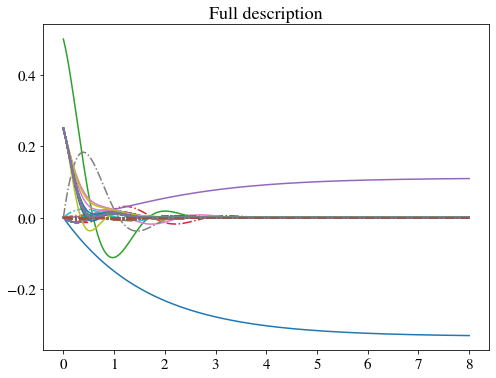

In [11]:
plt.title("Full description")

for j in range(3+int(3*a_cut)):
    plt.plot(t,np.real(z[:,j]),label="Re"+str(j))
    plt.plot(t,np.imag(z[:,j]),'-.',label="Im"+str(j))

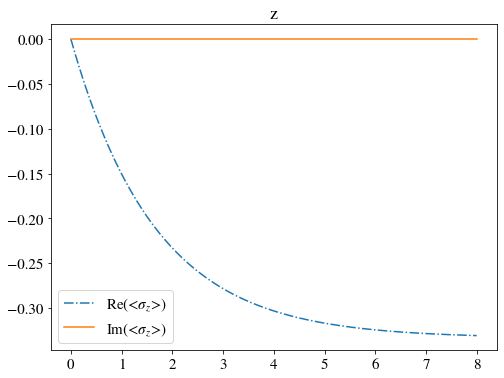

In [12]:
plt.title("z")

plt.plot(t,np.real(z[:,0]),'-.',label="Re(<$\sigma_z$>)")
plt.plot(t,np.imag(z[:,0]),label="Im(<$\sigma_z$>)")
plt.legend()

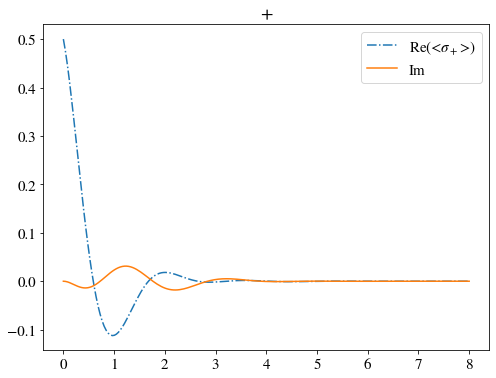

In [13]:
plt.title("+")

plt.plot(t,np.real(z[:,1]),'-.',label="Re(<$\sigma_+$>)")
plt.plot(t,np.imag(z[:,1]),label="Im")
plt.legend()

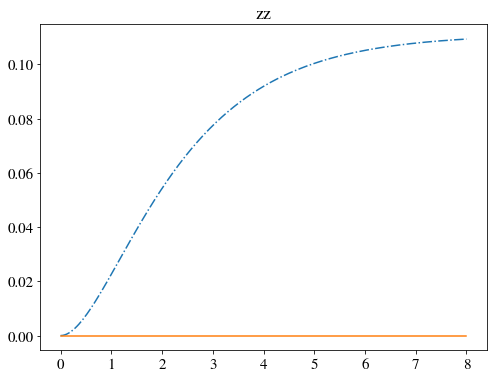

In [14]:
plt.title("zz")

plt.plot(t,np.real(z[:,2]),'-.',label="Re"+str(j))
plt.plot(t,np.imag(z[:,2]),label="Im"+str(j))
    #plt.legend()

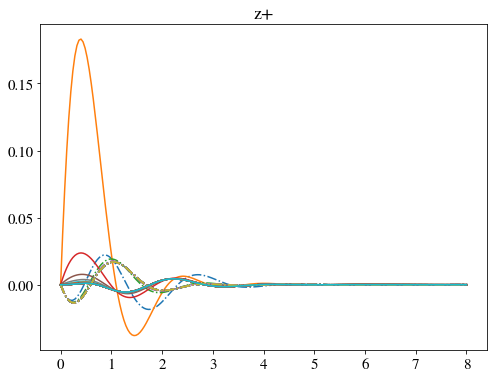

In [15]:
plt.title("z+")
for j in range(3,3+int(a_cut)):
    plt.plot(t,np.real(z[:,j]),'-.',label="Re"+str(j))
    plt.plot(t,np.imag(z[:,j]),label="Im"+str(j))
    #plt.legend()

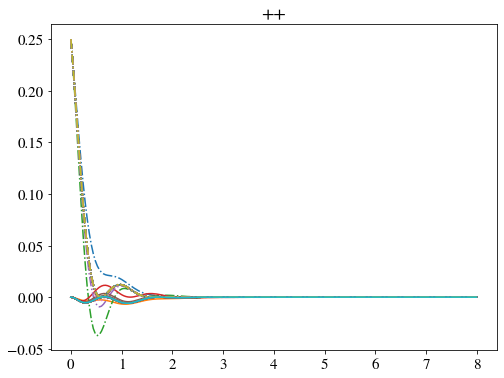

In [16]:
plt.title("++")

for j in range(3+int(a_cut),3+int(2*a_cut)):
    plt.plot(t,np.real(z[:,j]),'-.',label="Re"+str(j))
    plt.plot(t,np.imag(z[:,j]),label="Im"+str(j))
    #plt.legend()

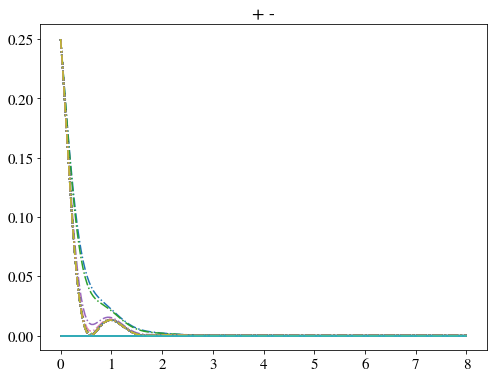

In [17]:
plt.title("+ -")

for j in range(3+int(2*a_cut),3+int(3*a_cut)):
    plt.plot(t,np.real(z[:,j]),'-.',label="Re"+str(j))
    plt.plot(t,np.imag(z[:,j]),label="Im"+str(j))

In [18]:
gamma_r=gamma_ud+gamma_du


gamma=(gamma_ud-gamma_du)/4

Tot=gamma_r+gamma_el
lamda=gamma_r/2

r=gamma_ud*gamma_du

# Those test works for $\left|+\right>$ solely

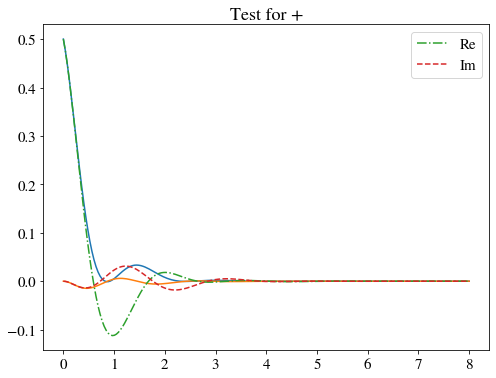

In [19]:
#Test for plus

plt.title("Test for +")

def Phi(t,j):
    
    func=1
    s=2*1j*gamma+2*J_aver/( (d**epsilon)* (abs(j)**epsilon))
    func=func*( np.exp(-lamda*t) )*(np.cos(t*(s**2-r)**0.5)+lamda*np.sin(t*(s**2-r)**0.5)/((s**2-r+1e-11)**0.5)) 
    
    return func          
   



def gen_p0(t):
    
    gen_ret=0.5*np.exp(-Tot*t/2)
    
    for j in range(1,N+1):
        gen_ret=gen_ret*(Phi(t,j))**2
    
    return gen_ret
        


plt.plot(t,np.real(gen_p0(t)))
plt.plot(t,np.imag(gen_p0(t)))


plt.plot(t,np.real(z[:,1]),'-.',label="Re")
plt.plot(t,np.imag(z[:,1]),'--',label="Im")

plt.legend()

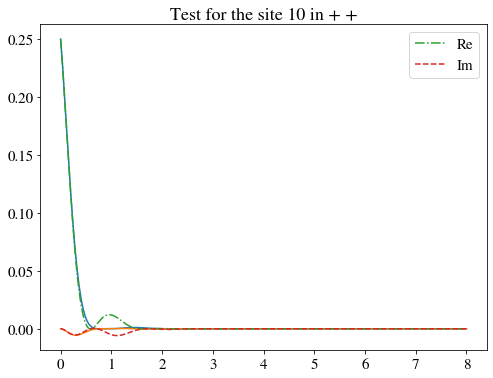

In [20]:
#Test for ++
def gen_pp(t,j):
    
    gen_ret=0.25*np.exp(-2*Tot*t/2)
    s=1

    for w in range(-N,N+1):
        if w!=j and w!=0:
            s=2*1j*gamma+2*( J_aver/( (d**epsilon)) )*(1/abs(w-j)**epsilon+1/abs(w)**epsilon )
            gen_ret=gen_ret*( np.exp(-lamda*t) )*(np.cos(t*(s**2-r)**0.5)+lamda*np.sin(t*(s**2-r)**0.5)/((s**2-r+1e-11)**0.5))
            
            
    return gen_ret

#-------------------------------------------


site=10
#site until a_cut

plt.title("Test for the site "+str(site)+" in + +")

plt.plot(t,np.real(gen_pp(t,site)))
plt.plot(t,np.imag(gen_pp(t,site)))

plt.plot(t,np.real(z[:,3+int((a_cut))+site]),'-.',label="Re")
plt.plot(t,np.imag(z[:,3+int((a_cut))+site]),'--',label="Im")

plt.legend()

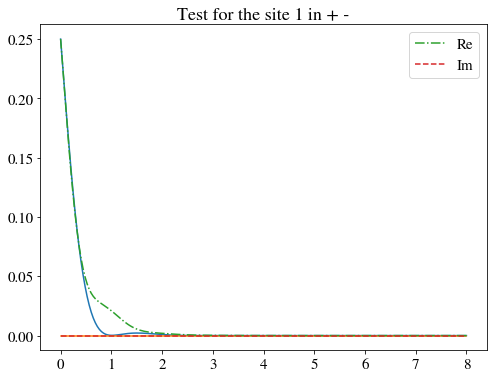

In [21]:
#Test for +-

def gen_pm(t,j):
    
    gen_ret=0.25*np.exp(-2*Tot*t/2)
    s=1

    for w in range(-int(N),int(N)+1):
        if w!=j and w!=0:
            s=2*1j*gamma+2*( J_aver/( (d**epsilon)) )*(1/abs(w-j)**epsilon-1/abs(w)**epsilon )
            gen_ret=gen_ret*( np.exp(-lamda*t) )*(np.cos(t*(s**2-r)**0.5)+lamda*np.sin(t*(s**2-r)**0.5)/((s**2-r+1e-11)**0.5))
            
            
    return gen_ret

#------------------------------------


site=1


plt.title("Test for the site "+str(site)+" in + -")

plt.plot(t,np.real(gen_pm(t,site)))

plt.plot(t,np.imag(gen_pm(t,site)))



plt.plot(t,np.real(z[:,3+int(2*(a_cut))+site]),'-.',label="Re")
plt.plot(t,np.imag(z[:,3+int(2*(a_cut))+site]),'--',label="Im")


plt.legend()

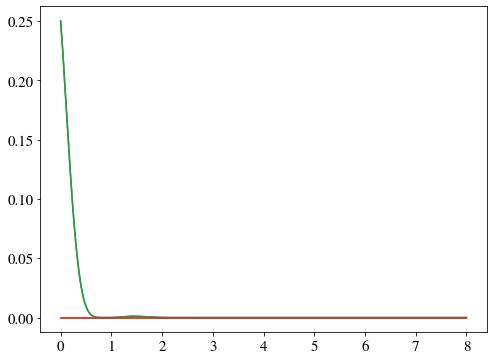

In [22]:
#Test for reflection symmetry


site=-10

plt.plot(t,np.real(gen_pm(t,site)))

plt.plot(t,np.imag(gen_pm(t,site)))

site=10

plt.plot(t,np.real(gen_pm(t,site)))

plt.plot(t,np.imag(gen_pm(t,site)))

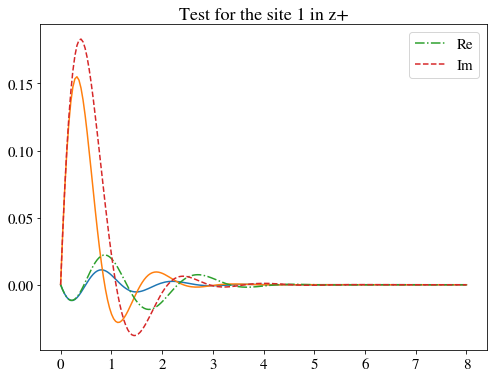

In [23]:
#Test zp

def gen_zp(t,j):
    fun=0.5*np.exp(-Tot*t/2)
    s=2*1j*gamma+2*( J_aver/( (d**epsilon)) )*(1/abs(j)**epsilon)
    fun=fun*np.exp(-lamda*t)*(1j*s-2*gamma)*np.sin(t*(s**2-r)**0.5)/((s**2-r+1e-11)**0.5)
    
    for w in range(-int(N),int(N)+1):
        if w!=j and w!=0:
            s=2*1j*gamma+2*( J_aver/( (d**epsilon)) )*(1/abs(w)**epsilon )
            fun=fun*( np.exp(-lamda*t) )*(np.cos(t*(s**2-r)**0.5)+lamda*np.sin(t*(s**2-r)**0.5)/((s**2-r+1e-11)**0.5))
            
            
    
    
    return fun



site=1


plt.title("Test for the site "+str(site)+" in z+")

plt.plot(t,np.real(gen_zp(t,site)))
plt.plot(t,np.imag(gen_zp(t,site)))



plt.plot(t,np.real(z[:,2+site]),'-.',label="Re")
plt.plot(t,np.imag(z[:,2+site]),'--',label="Im")

plt.legend()

In [24]:
N

100

Tests end here!

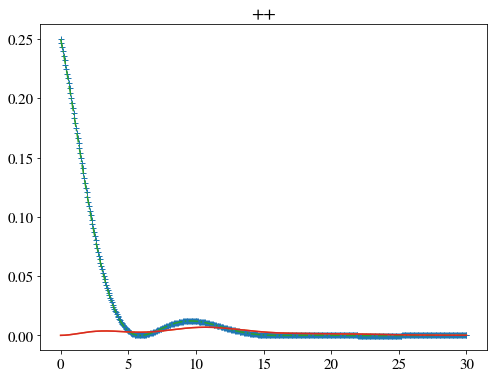

In [532]:
plt.title("++")

#for j in range(3+int(a_cut),3+int(2*a_cut)):

j=3+int(a_cut)

#plt.plot(t,np.real(z[:,j]),'-.',label="Re"+str(j))
#plt.plot(t,np.imag(z[:,j]),label="Im"+str(j))

#plt.plot(t,np.real(z[:,j+1]),'-.',label="Re"+str(j))
#plt.plot(t,np.imag(z[:,j+1]),label="Im"+str(j))

plt.plot(t,np.real(z[:,3+int(a_cut)+100]),'+',label="Re"+str(j))
plt.plot(t,np.imag(z[:,3+int(a_cut)]+100),label="Im"+str(j))

plt.plot(t,np.real(z[:,3+int(a_cut)+101]),'-.',label="Re"+str(j))
plt.plot(t,np.imag(z[:,3+int(a_cut)]+101),label="Im"+str(j))

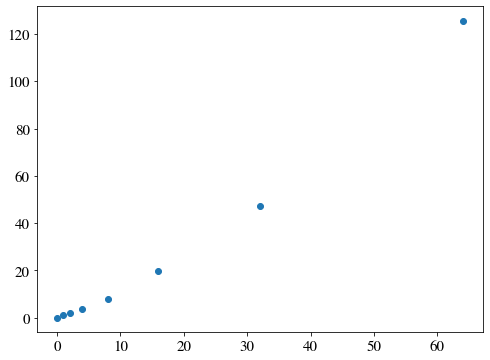

In [47]:
a_cutlist=[0,1,2 ,4 ,8 ,16,32,64,128,256,512,1024]
time_acut=[0.0472,1.073,2.138, 3.855,8.031,19.791,47.399,125.481, 463.041 , 1880.555,5420.327,  15134.7520]


plt.scatter(a_cutlist[:8],time_acut[:8])

plt.yscale("linear")

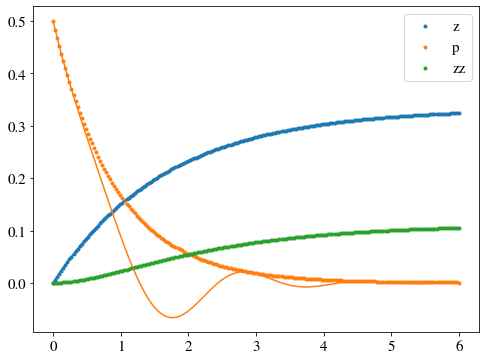

In [1207]:
## Use this cell to check pure decay solely


for j in range(3+int(3*a_cut)):
    plt.plot(t,np.real(z[:,j]))

    
def f1(t):
    return  (gamma_plus-gamma_minus)*(1-np.exp(-2*(gamma_plus+gamma_minus)*t))/(gamma_plus+gamma_minus)    


def f3(t):
    return ( (gamma_plus-gamma_minus)*(1-np.exp(-2*(gamma_plus+gamma_minus)*t))/(gamma_plus+gamma_minus) )**2
    
def f2(t):
    return  (1/2)*np.exp(-(gamma_plus+gamma_minus+4*gamma_z)*t)   

def f4(t):
    return  (1/2)*np.exp(-(gamma_plus+gamma_minus+4*gamma_z)*t) * (gamma_plus-gamma_minus)*(1-np.exp(-2*(gamma_plus+gamma_minus)*t))/(gamma_plus+gamma_minus) 

def f5(t):
    return  f3(t)*f3(t)

def f6(t):
    return  f3(t)*f3(t)

plt.scatter(t,f1(t),marker='.', label="z")   
plt.scatter(t,f2(t),marker='.', label="p") 
plt.scatter(t,f3(t),marker='.', label="zz") 
#plt.scatter(t,f4(t),marker='.', label="zp")
#plt.scatter(t,f5(t),marker='.', label="pp")
#plt.scatter(t,f6(t),marker='+', label="pm")
      

plt.legend()

In [1124]:
g_trun(epsilon,0,0,partial_terms)

2.0346861239298875

In [1158]:
a_cut=0
for j in range(0,a_cut):
    print(j)

for w in range(1,a_cut+1):
    print(a)

In [1160]:
g_trun(epsilon,0,0,partial_terms)/zeta(epsilon)

1.999999999961654

In [1166]:
a_cut=0
partial_terms=100

def zfunc(z, t):
    z0, p0 = z
    
    gamps=gamma_plus+gamma_minus+4*gamma_z
    gam1=3*(gamma_plus+gamma_minus)+4*gamma_z
    dz0dt=2*(gamma_plus-gamma_minus)-2*(gamma_plus+gamma_minus)*z0
    dp0dt=2j*(J/(d**epsilon))*z0*p0*g_trun(epsilon,a_cut,0,partial_terms)  -gamps*p0
        
    return [ dz0dt,dp0dt] 

z0=[0,1/2]

g, infodict = odeintz(zfunc, z0, t, full_output=1)

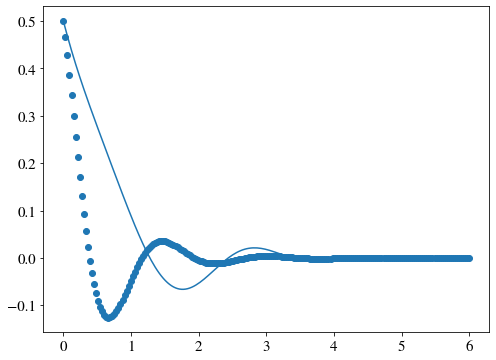

In [1172]:
plt.plot(t,np.real(g[:,1]))


def comp_p0(t):
    v1=0.5*np.exp( (np.exp(-2*(gamma_plus+gamma_minus)*t)-1)/(2*(gamma_plus+gamma_minus)) )
    v1=v1*np.exp(-(gamma_plus+gamma_minus+4*gamma_z)*t)*np.cos(4*zeta(epsilon)*(J/d**epsilon)*( (gamma_plus-gamma_minus)/(gamma_plus+gamma_minus)  )*t)
    
    return v1

plt.scatter(t,comp_p0(t))

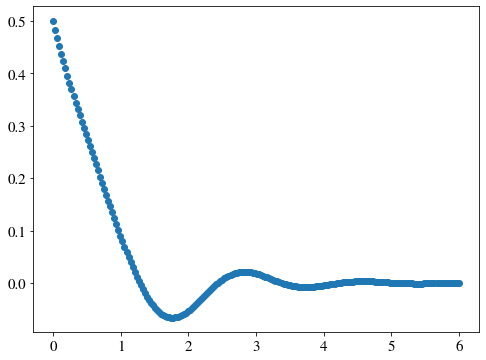

In [1198]:
def comp_p0(t):
    v1=0.5*np.exp(-(gamma_plus+gamma_minus+4*gamma_z) *t )
    gp=gamma_plus+gamma_minus
    gm=gamma_plus-gamma_minus
    
    v1=v1*np.cos(4*zeta(epsilon)*(J/d**epsilon)*( gm/gp  ) *(t+ (np.exp(-2*(gp)*t) -1)/(2*gp) ))
    
    return v1

plt.scatter(t,comp_p0(t))

In [479]:
def zfunc(z, t):
    sx, sy= z
            
    dsxdt=4*zeta(epsilon)*(J_aver/d**epsilon)*sy
    dsydt=-4*zeta(epsilon)*(J_aver/d**epsilon)*sx 
    
    return [dsxdt, dsydt] 

# Set up the inputs and call odeintz to solve the system.
z0=[1,-1]


z = odeintz(zfunc, z0, t)


C:\Users\camil\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


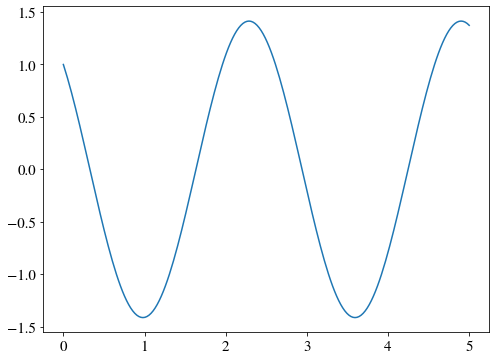

In [480]:
plt.plot(t,z[:,0])

## TWA without noise

In [305]:
from random import choices

In [306]:
#Initial
def zfunc(z, t,a=1):
    sx, sy= z
    
        
    dsxdt=4*zeta(epsilon)*(J_aver/d**epsilon)*sy  *a
    dsydt=-4*zeta(epsilon)*(J_aver/d**epsilon)*sx   *a
    
    return [dsxdt, dsydt] 



In [307]:
def history(n):
    z00=(choices([-1,1]))[0]
    z01=(choices([-1,1]))[0]
    
    z0=[z00,z01]
    z = odeintz(zfunc, z0, t)
    
    sx_list=np.array(z[:,0])
    sy_list=np.array(z[:,1])
    sxsy_list= np.array([z[:,0][i] *z[:,1][i] for i in range(len(z[:,0]))])
    sxsx_list= np.array([z[:,0][i] *z[:,0][i] for i in range(len(z[:,0]))])
    sysy_list= np.array([z[:,1][i] *z[:,1][i] for i in range(len(z[:,0]))])
    
    
    
    
    for j in range(2,n+1):
        
        z0=[(choices([-1,1]))[0],(choices([-1,1]))[0]]
        z = odeintz(zfunc, z0, t)
        
        sx_list = np.add(((j-1)/j)*(sx_list),(1/j)*np.array(z[:,0]))
        sy_list = np.add(((j-1)/j)*(sy_list),(1/j)*np.array(z[:,1]))
        w_xy=     np.array([z[:,0][i] *z[:,1][i] for i in range(len(z[:,0]))])
        w_xx=     np.array([z[:,0][i] *z[:,0][i] for i in range(len(z[:,0]))])
        w_yy=     np.array([z[:,1][i] *z[:,1][i] for i in range(len(z[:,0]))])
        sxsy_list= np.add(((j-1)/j)*(sxsy_list),(1/j)*w_xy)
        sxsx_list= np.add(((j-1)/j)*(sxsx_list),(1/j)*w_xx)
        sysy_list= np.add(((j-1)/j)*(sysy_list),(1/j)*w_yy)
            

    return sx_list,sy_list,sxsy_list,sxsx_list,sysy_list
    

In [308]:
import time

t0=time.time()

n=50

results=history(n)

t1=time.time()

print(n,t1-t0)


50 0.43199968338012695


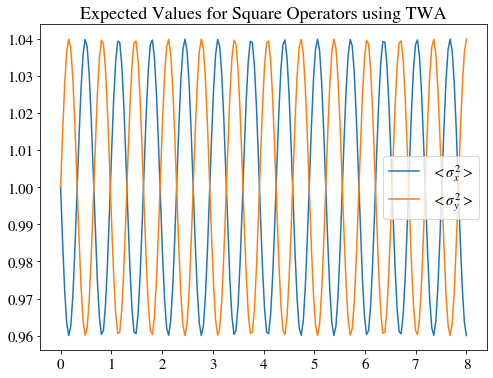

In [309]:
plt.title("Expected Values for Square Operators using TWA")

plt.plot(t,np.real(results[3]),label="$<\sigma^2_x>$")
plt.plot(t,np.real(results[4]),label="$<\sigma^2_y>$")

plt.legend()

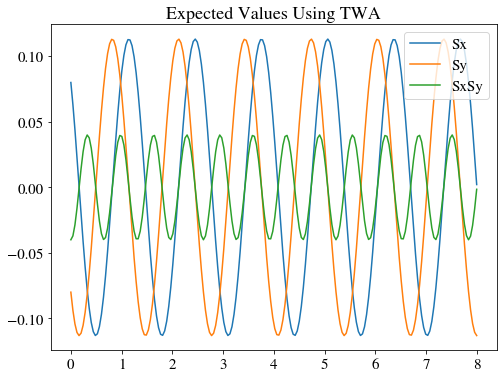

In [310]:
plt.title("Expected Values Using TWA")

plt.plot(t,np.real(results[0]),label="Sx")
plt.plot(t,np.real(results[1]),label="Sy")
plt.plot(t,np.real(results[2]),label="SxSy")


plt.legend()

In [143]:
## Finite size test


def gen_pm(t,j,N=10):
    
    gen_ret=0.25*np.exp(-2*Tot*t/2)
    s=1

    for w in range(-int(N),int(N)+1):
        if w!=j and w!=0:
            s=2*1j*gamma+2*( J_aver/( (d**epsilon)) )*(1/abs(w-j)**epsilon-1/abs(w)**epsilon )
            gen_ret=gen_ret*( np.exp(-lamda*t) )*(np.cos(t*(s**2-r)**0.5)+lamda*np.sin(t*(s**2-r)**0.5)/((s**2-r)**0.5))
            
            
    return gen_ret

C:\Users\camil\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


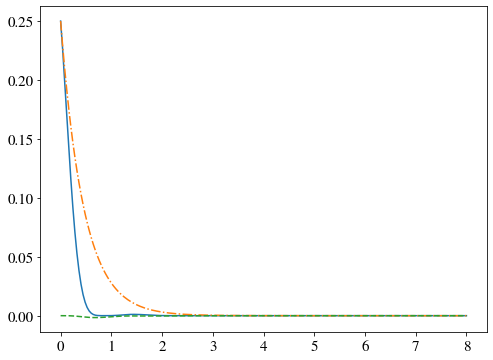

In [149]:
plt.plot(t,gen_pm(t,10000,100000))
site=1
plt.plot(t,np.real(z[:,3+int(2*(a_cut))+site]),'-.',label="Re")
plt.plot(t,np.imag(z[:,3+int(2*(a_cut))+site]),'--',label="Im") 

In [44]:
def trace(A):
    
    """Returns the trace of a square matrix
    
    Inputs:
    ----------
      -array: array associated to the matrix that we want to determine the trace
    
    Return:
      -complex: return a complex number which is the trace of the matrix of the input""" 
    
    
    return np.trace(A)  #Returns the trace of a square matrix


def matmu(A,B):
    """Perform the matrix multiplication of the matrices A and B of the form A.B
    
    Inputs:
    ----------
      -arrays: two array associated to the matrices A and B respectively
    
    Return:
      -array: array with the result of A.B or raises an error otherwise""" 
    
    return np.matmul(A,B) #Returns the result of the multiplication of matrix A and B in the order A.B

In [46]:
rho_init0=np.array([[0,0],[0,1]])

sigma_p= np.array([[0,1],[0,0]])  #Matrix sigma+
sigma_m= np.array([[0,0],[1,0]])  #Matrix sigma-
sigma_z= np.array([[1,0],[0,-1]]) #Matrix sigmaz


##Initial values per operator

sp_init0=trace(matmu(rho_init0,sigma_p))  #initial value for sigma+
sz_init0=trace(matmu(rho_init0,sigma_z))  #initial value for sigma-
sm_init0=trace(matmu(rho_init0,sigma_m))  #initial value for sigmaz

In [246]:
#Initial

#length_side=2
#N=length_side**3

N=40
J=1
epsilon=0

refgamma=0  #Fixed
refomega=5



Gamma_phi=refgamma*J
Omega=refomega*J
dist_ar=1



def zfunc(g, t,a=1):
    p, z, pp, pm, zp, zz= g
    
    dpdt =-1j*(Omega/2)*z+2j*J*((N-1)/N)*zp-Gamma_phi*p
    dzdt =2*Omega*np.imag(p)
    dppdt=-1j*Omega*zp+4j*J*((N-2)/N)*(pp*z+2*zp*p-2*(p**2)*z)-2*Gamma_phi*pp
    dpmdt=-Omega*np.imag(zp)-2*Gamma_phi*pm
    #dzpdt=-1j*Omega*(pp-np.conjugate(pm)-zp)+2j*(J/N)*(p+(N-2)*(2*zp*z+zz*p-2*p*z**2)  )-Gamma_phi*zp
    dzpdt=-1j*(Omega/2)*(2*(pp-pm)+zz)+2j*(J/N)*(p+(N-2)*(2*zp*z+zz*p-2*p*z**2)  )-Gamma_phi*zp
    dzzdt=4*Omega*np.imag(zp)
    
    
    
    return [dpdt,dzdt,dppdt,dpmdt,dzpdt,dzzdt] 


sp_init0
sz_init0
sm_init0

z0=[sp_init0,sz_init0,sp_init0**2,sp_init0*sm_init0,sz_init0*sp_init0,sz_init0**2]


t=np.linspace(0,3,60)
z = odeintz(zfunc, z0, t)



C:\Users\camil\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-20.0, 20.0)

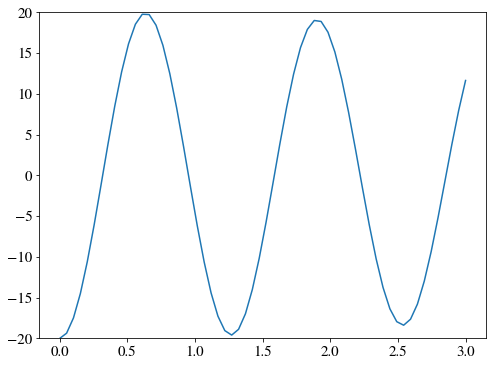

In [247]:
plt.plot(t,20*z[:,1])
plt.ylim(-20,20)

In [248]:
20*z[:,1]

array([-20.        +0.j, -19.35762524+0.j, -17.47747194+0.j,
       -14.49395919+0.j, -10.61191923+0.j,  -6.08492887+0.j,
        -1.19510694+0.j,   3.76229314+0.j,   8.49001894+0.j,
        12.6990484 +0.j,  16.12181186+0.j,  18.53032008+0.j,
        19.75750127+0.j,  19.71665051+0.j,  18.41276873+0.j,
        15.94172805+0.j,  12.47763749+0.j,   8.25295339+0.j,
         3.53745456+0.j,  -1.37937246+0.j,  -6.20142948+0.j,
       -10.6367374 +0.j, -14.40942256+0.j, -17.27562557+0.j,
       -19.04310752+0.j, -19.5909615 +0.j, -18.88391457+0.j,
       -16.97654022+0.j, -14.00602547+0.j, -10.17611763+0.j,
        -5.73731625+0.j,  -0.96814415+0.j,   3.84008723+0.j,
         8.39564464+0.j,  12.41850369+0.j,  15.65486562+0.j,
        17.89472307+0.j,  18.99030997+0.j,  18.87120587+0.j,
        17.55184007+0.j,  15.12924958+0.j,  11.77202637+0.j,
         7.70382264+0.j,   3.18545414+0.j,  -1.50153946+0.j,
        -6.06921396+0.j, -10.23668468+0.j, -13.74458154+0.j,
       -16.37127041+0.j,

Results!!!!

In [215]:

#This is for all-to-all interactions
#Gamma/J=0.2-----> There is dephasing, non-unitary evolution



twaomega1=np.array([-20.        , -19.95754513, -19.86452293, -19.72255117,
       -19.53379787, -19.30091869, -19.02698292, -18.71539155,
       -18.36979142, -17.99398895, -17.59186675, -17.16730598,
       -16.72411674, -16.26597783, -15.79638693, -15.31862136,
       -14.83570928, -14.35041064, -13.86520693, -13.38229862,
       -12.90360905, -12.43079363, -11.96525294, -11.50814893,
       -11.060423  , -10.62281527, -10.19588429,  -9.78002663,
        -9.37549604,  -8.98242159,  -8.60082493,  -8.23063619,
        -7.87170871,  -7.52383241,  -7.18674589,  -6.86014732,
        -6.54370411,  -6.23706157,  -5.93985048,  -5.6516938 ,
        -5.37221255,  -5.10103093,  -4.83778076,  -4.58210533,
        -4.3336627 ,  -4.09212854,  -3.85719846,  -3.62858998,
        -3.4060441 ,  -3.18932649,  -2.97822838,  -2.77256705,
        -2.57218602,  -2.37695499,  -2.18676933,  -2.00154941,
        -1.82123953,  -1.64580664,  -1.47523875,  -1.30954314])

cumulomega1=np.array([-20.        +0.j, -19.97425939+0.j, -19.89770052+0.j,
       -19.77176785+0.j, -19.59846727+0.j, -19.3803065 +0.j,
       -19.12022359+0.j, -18.82150686+0.j, -18.4877103 +0.j,
       -18.12256794+0.j, -17.7299105 +0.j, -17.31358719+0.j,
       -16.87739499+0.j, -16.42501697+0.j, -15.95997059+0.j,
       -15.48556651+0.j, -15.00487757+0.j, -14.52071763+0.j,
       -14.0356291 +0.j, -13.55187843+0.j, -13.07145811+0.j,
       -12.5960941 +0.j, -12.12725761+0.j, -11.66617989+0.j,
       -11.21386937+0.j, -10.77113005+0.j, -10.33858063+0.j,
        -9.91667362+0.j,  -9.5057142 +0.j,  -9.10587829+0.j,
        -8.71722973+0.j,  -8.3397363 +0.j,  -7.97328467+0.j,
        -7.61769397+0.j,  -7.27272832+0.j,  -6.93810802+0.j,
        -6.61351974+0.j,  -6.29862564+0.j,  -5.99307149+0.j,
        -5.69649402+0.j,  -5.40852734+0.j,  -5.12880883+0.j,
        -4.85698428+0.j,  -4.59271258+0.j,  -4.33566982+0.j,
        -4.08555309+0.j,  -3.84208379+0.j,  -3.60501066+0.j,
        -3.37411244+0.j,  -3.14920025+0.j,  -2.93011966+0.j,
        -2.71675242+0.j,  -2.50901793+0.j,  -2.30687431+0.j,
        -2.11031906+0.j,  -1.91938942+0.j,  -1.7341621 +0.j,
        -1.55475269+0.j,  -1.38131438+0.j,  -1.21403612+0.j])


twaomega2=np.array([-2.00000000e+01, -1.99110137e+01, -1.96208449e+01, -1.91372033e+01,
       -1.84712287e+01, -1.76368637e+01, -1.66501143e+01, -1.55282784e+01,
       -1.42892082e+01, -1.29506673e+01, -1.15298187e+01, -1.00428637e+01,
       -8.50483262e+00, -6.92951686e+00, -5.32951921e+00, -3.71639733e+00,
       -2.10087168e+00, -4.93070210e-01,  1.09721651e+00,  2.66029332e+00,
        4.18635273e+00,  5.66531955e+00,  7.08676246e+00,  8.43988324e+00,
        9.71358919e+00,  1.08966485e+01,  1.19779214e+01,  1.29466534e+01,
        1.37928103e+01,  1.45074290e+01,  1.50829570e+01,  1.55135531e+01,
        1.57953233e+01,  1.59264750e+01,  1.59073790e+01,  1.57405362e+01,
        1.54304571e+01,  1.49834673e+01,  1.44074581e+01,  1.37116022e+01,
        1.29060583e+01,  1.20016825e+01,  1.10097625e+01,  9.94178932e+00,
        8.80927058e+00,  7.62359176e+00,  6.39592231e+00,  5.13716350e+00,
        3.85793084e+00,  2.56856256e+00,  1.27914458e+00, -4.57943812e-04,
       -1.26057163e+00, -2.49169687e+00, -3.68450728e+00, -4.82987115e+00,
       -5.91889712e+00, -6.94300393e+00, -7.89401164e+00, -8.76424979e+00])


cumulomega2=np.array([-20.        +0.j, -19.89710372+0.j, -19.59184645+0.j,
       -19.0922359 +0.j, -18.40969541+0.j, -17.55842635+0.j,
       -16.55466414+0.j, -15.41590348+0.j, -14.1601625 +0.j,
       -12.80534212+0.j, -11.36871841+0.j,  -9.86658665+0.j,
        -8.31405868+0.j,  -6.72500108+0.j,  -5.11209319+0.j,
        -3.48697827+0.j,  -1.86047933+0.j,  -0.24285167+0.j,
         1.35595479+0.j,   2.92604751+0.j,   4.45737981+0.j,
         5.93959485+0.j,   7.36194106+0.j,   8.71327085+0.j,
         9.98212888+0.j,  11.15692996+0.j,  12.22621856+0.j,
        13.17899397+0.j,  14.00507735+0.j,  14.69549109+0.j,
        15.24281812+0.j,  15.64150955+0.j,  15.88811417+0.j,
        15.98141159+0.j,  15.92244081+0.j,  15.71442714+0.j,
        15.36261949+0.j,  14.87405697+0.j,  14.2572877 +0.j,
        13.52206374+0.j,  12.67903417+0.j,  11.73945536+0.j,
        10.71493315+0.j,   9.61720686+0.j,   8.45798094+0.j,
         7.24880548+0.j,   6.00100325+0.j,   4.72563782+0.j,
         3.43351469+0.j,   2.13520523+0.j,   0.84108237+0.j,
        -0.43864369+0.j,  -1.69390107+0.j,  -2.91475291+0.j,
        -4.09142295+0.j,  -5.21435448+0.j,  -6.27430337+0.j,
        -7.26246168+0.j,  -8.17060412+0.j,  -8.99124634+0.j])


twaomega3=np.array([-2.00000000e+01, -1.97952401e+01, -1.91271626e+01, -1.80220275e+01,
       -1.65186561e+01, -1.46654164e+01, -1.25169323e+01, -1.01310389e+01,
       -7.56637107e+00, -4.88078180e+00, -2.13058869e+00,  6.29509367e-01,
        3.34610723e+00,  5.96666567e+00,  8.43927865e+00,  1.07128805e+01,
        1.27380463e+01,  1.44684149e+01,  1.58626284e+01,  1.68865468e+01,
        1.75154067e+01,  1.77355642e+01,  1.75455150e+01,  1.69560084e+01,
        1.59892412e+01,  1.46772818e+01,  1.30599942e+01,  1.11827918e+01,
        9.09452168e+00,  6.84571041e+00,  4.48728687e+00,  2.06978721e+00,
       -3.57049240e-01, -2.74444779e+00, -5.04471248e+00, -7.21145985e+00,
       -9.20010558e+00, -1.09686720e+01, -1.24789054e+01, -1.36976146e+01,
       -1.45980757e+01, -1.51613176e+01, -1.53771027e+01, -1.52444583e+01,
       -1.47716828e+01, -1.39758310e+01, -1.28817587e+01, -1.15208595e+01,
       -9.92965690e+00, -8.14840351e+00, -6.21981192e+00, -4.18799032e+00,
       -2.09760153e+00,  6.78533941e-03,  2.08121785e+00,  4.08284225e+00,
        5.97042539e+00,  7.70497583e+00,  9.25048805e+00,  1.05747937e+01])



cumulomega3=np.array([-20.        +0.j, -19.76873188+0.j, -19.08556063+0.j,
       -17.97679195+0.j, -16.48064935+0.j, -14.64434545+0.j,
       -12.5209256 +0.j, -10.16637239+0.j,  -7.63732864+0.j,
        -4.98961503+0.j,  -2.27753666+0.j,   0.44617288+0.j,
         3.13001625+0.j,   5.72329394+0.j,   8.17584532+0.j,
        10.43820451+0.j,  12.4623226 +0.j,  14.20289412+0.j,
        15.61919393+0.j,  16.67720471+0.j,  17.3517214 +0.j,
        17.62808738+0.j,  17.50326182+0.j,  16.98603212+0.j,
        16.09634289+0.j,  14.86387035+0.j,  13.32609138+0.j,
        11.52615162+0.j,   9.51082532+0.j,   7.32879078+0.j,
         5.02934677+0.j,   2.66158805+0.j,   0.27396611+0.j,
        -2.08590441+0.j,  -4.37136571+0.j,  -6.53693292+0.j,
        -8.53874177+0.j, -10.33530261+0.j, -11.88855832+0.j,
       -13.16516339+0.j, -14.13783662+0.j, -14.78660423+0.j,
       -15.09975511+0.j, -15.07437301+0.j, -14.71637945+0.j,
       -14.04009883+0.j, -13.06742404+0.j, -11.82670473+0.j,
       -10.35149778+0.j,  -8.67931058+0.j,  -6.85044004+0.j,
        -4.90697047+0.j,  -2.89194851+0.j,  -0.84871168+0.j,
         1.17968531+0.j,   3.15101919+0.j,   5.02449203+0.j,
         6.76141971+0.j,   8.32602816+0.j,   9.68632819+0.j])


twaomega4=np.array([-20.        , -19.65544343, -18.50780953, -16.62224581,
       -14.09598032, -11.04916426,  -7.6157708 ,  -3.93624398,
        -0.15261703,   3.59419831,   7.16598503,  10.4289806 ,
        13.25696917,  15.53627375,  17.17238933,  18.09717131,
        18.27496863,  17.70611425,  16.4268021 ,  14.50536522,
        12.03592488,   9.13092971,   5.91408413,   2.51466671,
        -0.93648299,  -4.30969993,  -7.47876118, -10.32357181,
       -12.73389717, -14.61426254, -15.88954332, -16.5102834 ,
       -16.4565963 , -15.73971633, -14.4008116 , -12.50734143,
       -10.14778324,  -7.4257834 ,  -4.45466192,  -1.35281744,
         1.75989441,   4.76513418,   7.54893392,  10.00493336,
        12.03825115,  13.56987208,  14.54105956,  14.91706814,
        14.68942968,  13.87633026,  12.52099794,  10.68843686,
         8.46112701,   5.93438063,   3.21191076,   0.40190143,
        -2.38642138,  -5.04593557,  -7.47478372,  -9.57977438])


cumulomega4=np.array([-20.        +0.j, -19.58947453+0.j, -18.38401382+0.j,
       -16.45073193+0.j, -13.88788189+0.j, -10.815832  +0.j,
        -7.36820566+0.j,  -3.68478284+0.j,   0.09319245+0.j,
         3.82563518+0.j,   7.37520684+0.j,  10.60916243+0.j,
        13.40255343+0.j,  15.64329613+0.j,  17.23879704+0.j,
        18.12302762+0.j,  18.26245637+0.j,  17.659308  +0.j,
        16.35125003+0.j,  14.40757583+0.j,  11.92286814+0.j,
         9.00963618+0.j,   5.79137589+0.j,   2.3970033 +0.j,
        -1.04309695+0.j,  -4.39981407+0.j,  -7.54764655+0.j,
       -10.3674864 +0.j, -12.75043249+0.j, -14.6026995 +0.j,
       -15.85110675+0.j, -16.44818587+0.j, -16.37581468+0.j,
       -15.64653214+0.j, -14.30222811+0.j, -12.41052582+0.j,
       -10.05965382+0.j,  -7.3527895 +0.j,  -4.40272272+0.j,
        -1.32732713+0.j,   1.75411089+0.j,   4.72401585+0.j,
         7.46958184+0.j,   9.88618898+0.j,  11.88134157+0.j,
        13.37893421+0.j,  14.32333495+0.j,  14.68262453+0.j,
        14.45040597+0.j,  13.64586497+0.j,  12.31210987+0.j,
        10.51312673+0.j,   8.32986294+0.j,   5.85597114+0.j,
         3.19362604+0.j,   0.44962513+0.j,  -2.26822654+0.j,
        -4.8545925 +0.j,  -7.21011611+0.j,  -9.24504383+0.j])

cumulomega5=np.array([-20.        , -19.44084159, -17.64702386, -14.75907259,
       -10.98624401,  -6.58397351,  -1.83302286,   2.97640845,
         7.55612347,  11.6300902 ,  14.94688653,  17.2960787 ,
        18.52693825,  18.56499634,  17.42110952,  15.1896976 ,
        12.03664214,   8.18082032,   3.87450214,  -0.61351752,
        -5.01101157,  -9.05321308, -12.49420695, -15.12074374,
       -16.76819439, -17.3358958 , -16.79780167, -15.20504112,
       -12.67945458,  -9.40008814,  -5.58641614,  -1.48193275,
         2.65992976,   6.58771766,  10.06327354,  12.874074  ,
        14.8469746 ,  15.86193761,  15.86294816,  14.86323285,
        12.94323058,  10.2418571 ,   6.94336205,   3.26266664,
        -0.56862572,  -4.3147705 ,  -7.74749181, -10.65767951,
       -12.86770674, -14.2437519 , -14.70637333, -14.23714563,
       -12.879736  , -10.73513257,  -7.95217013,  -4.71535464,
        -1.2319477 ,   2.28048725,   5.60584127,   8.54090887])


twaomega5=np.array([-20.        +0.j, -19.35979354+0.j, -17.49437417+0.j,
       -14.54873645+0.j, -10.73492376+0.j,  -6.30966632+0.j,
        -1.55394684+0.j,   3.24252853+0.j,   7.79265574+0.j,
        11.82223854+0.j,  15.08268519+0.j,  17.36751309+0.j,
        18.53086969+0.j,  18.50353575+0.j,  17.30125774+0.j,
        15.02235805+0.j,  11.83533655+0.j,   7.96047143+0.j,
         3.65049563+0.j,  -0.82600273+0.j,  -5.19758179+0.j,
        -9.20095966+0.j, -12.59263559+0.j, -15.16284549+0.j,
       -16.75138055+0.j, -17.26245539+0.j, -16.67466721+0.j,
       -15.04291427+0.j, -12.49158638+0.j,  -9.20107949+0.j,
        -5.39127624+0.j,  -1.30540582+0.j,   2.80394844+0.j,
         6.68691283+0.j,  10.10792717+0.j,  12.85829319+0.j,
        14.76982111+0.j,  15.72803345+0.j,  15.68223975+0.j,
        14.64990925+0.j,  12.71413499+0.j,  10.01488819+0.j,
         6.73623991+0.j,   3.09213425+0.j,  -0.68738691+0.j,
        -4.36885629+0.j,  -7.72737154+0.j, -10.55864912+0.j,
       -12.69134324+0.j, -13.99879803+0.j, -14.40854186+0.j,
       -13.90770202+0.j, -12.54321899+0.j, -10.41690277+0.j,
        -7.67643076+0.j,  -4.50390885+0.j,  -1.10349368+0.j,
         2.31100379+0.j,   5.52826551+0.j,   8.35143545+0.j])





cumulomega0dot5=np.array([-20.        +0.j, -19.99356384+0.j, -19.97440879+0.j,
       -19.94286106+0.j, -19.8993685 +0.j, -19.84449225+0.j,
       -19.77889637+0.j, -19.70333665+0.j, -19.61864821+0.j,
       -19.52573257+0.j, -19.42554428+0.j, -19.31907759+0.j,
       -19.20735317+0.j, -19.0914054 +0.j, -18.97227014+0.j,
       -18.85097344+0.j, -18.72852106+0.j, -18.6058891 +0.j,
       -18.48401568+0.j, -18.36379373+0.j, -18.2460649 +0.j,
       -18.13161454+0.j, -18.02116772+0.j, -17.9153862 +0.j,
       -17.81486632+0.j, -17.72013765+0.j, -17.63166242+0.j,
       -17.54983552+0.j, -17.47498507+0.j, -17.4073735 +0.j,
       -17.34719892+0.j, -17.29459691+0.j, -17.24964254+0.j,
       -17.21235257+0.j, -17.18268789+0.j, -17.16055603+0.j,
       -17.14581381+0.j, -17.1382701 +0.j, -17.13768864+0.j,
       -17.14379088+0.j, -17.15625896+0.j, -17.17473873+0.j,
       -17.19884278+0.j, -17.22815361+0.j, -17.26222683+0.j,
       -17.30059441+0.j, -17.34276806+0.j, -17.38824263+0.j,
       -17.43649961+0.j, -17.48701065+0.j, -17.53924124+0.j,
       -17.5926543 +0.j, -17.6467139 +0.j, -17.70088896+0.j,
       -17.75465692+0.j, -17.80750741+0.j, -17.85894588+0.j,
       -17.90849705+0.j, -17.95570831+0.j, -18.00015301+0.j])


twaomega0dot5=np.array([-20.        , -19.99296801, -19.97314838, -19.94087367,
       -19.89659858, -19.84089137, -19.77442371, -19.69795929,
       -19.61234145, -19.51848014, -19.41733847, -19.30991919,
       -19.19725135, -19.08037736, -18.96034072, -18.83817452,
       -18.71489097, -18.59147183, -18.46886017, -18.34795304,
       -18.22959548, -18.11457549, -18.00362014, -17.89739264,
       -17.7964903 , -17.70144333, -17.61271438, -17.53069862,
       -17.45572451, -17.38805487, -17.32788843, -17.27536164,
       -17.23055076, -17.19347409, -17.16409436, -17.14232131,
       -17.12801424, -17.12098472, -17.12099931, -17.12778233,
       -17.14101871, -17.16035684, -17.18541155, -17.21576703,
       -17.25097998, -17.29058264, -17.33408609, -17.3809835 ,
       -17.43075349, -17.48286365, -17.53677403, -17.59194079,
       -17.64781982, -17.70387052, -17.75955948, -17.81436423,
       -17.86777698, -17.9193082 , -17.96849022, -18.01488066])

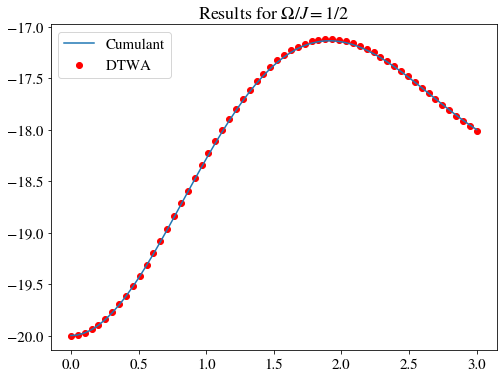

In [219]:
plt.title("Results for $\Omega/J=1/2$")

plt.scatter(t,twaomega0dot5,label="DTWA ",color="r")

plt.plot(t,np.real(cumulomega0dot5),label="Cumulant")
plt.legend()

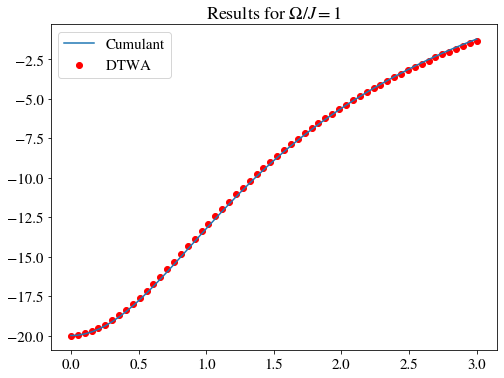

In [204]:
plt.title("Results for $\Omega/J=1$")

plt.scatter(t,twaomega1,label="DTWA ",color="r")

plt.plot(t,np.real(cumulomega1),label="Cumulant")
plt.legend()

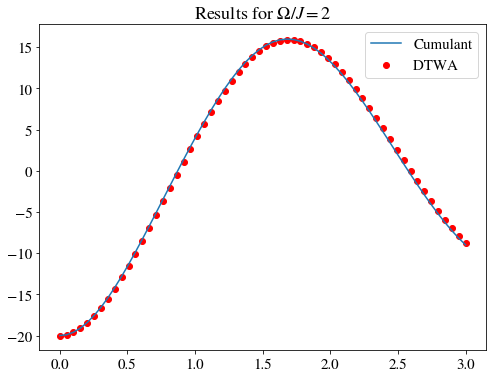

In [205]:
plt.title("Results for $\Omega/J=2$")


plt.scatter(t,twaomega2,label="DTWA ",color="r")

plt.plot(t,np.real(cumulomega2),label="Cumulant")
plt.legend()

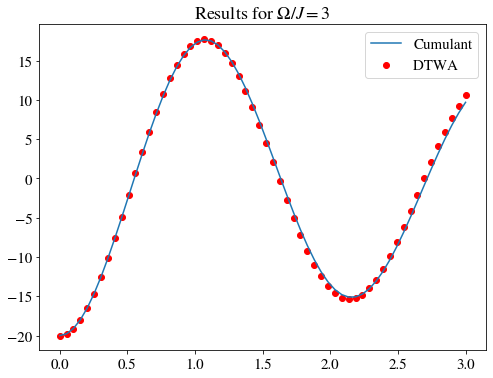

In [206]:
plt.title("Results for $\Omega/J=3$")


plt.scatter(t,twaomega3,label="DTWA ",color="r")

plt.plot(t,np.real(cumulomega3),label="Cumulant")
plt.legend()

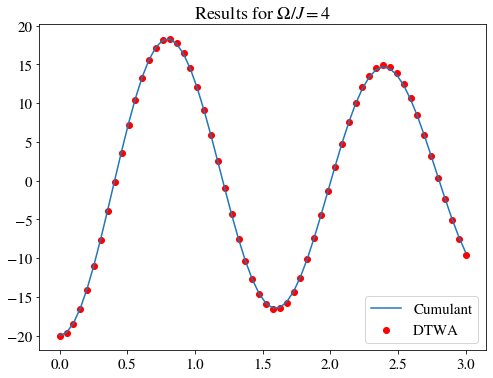

In [207]:
plt.title("Results for $\Omega/J=4$")


plt.scatter(t,twaomega4,label="DTWA ",color="r")

plt.plot(t,np.real(cumulomega4),label="Cumulant")
plt.legend()

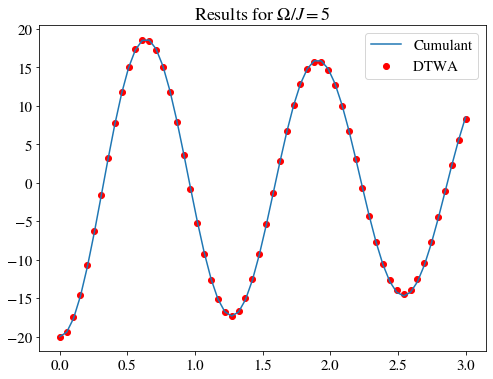

In [208]:
plt.title("Results for $\Omega/J=5$")


plt.scatter(t,np.real(twaomega5),label="DTWA ",color="r")

plt.plot(t,np.real(cumulomega5),label="Cumulant")
plt.legend()

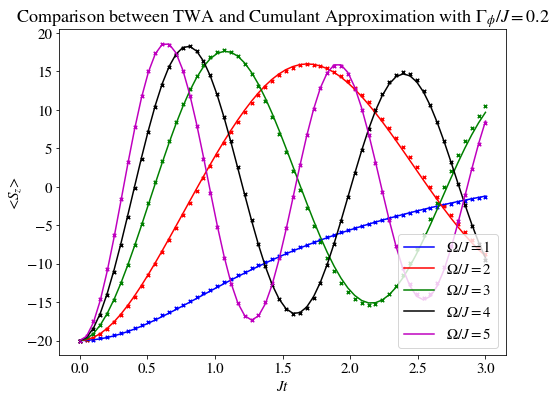

In [235]:
plt.title("Comparison between TWA and Cumulant Approximation with $\Gamma_{\phi}/J=0.2$")

plt.xlabel("$Jt$")
plt.ylabel("<$S_z$>")


plt.scatter(t,np.real(twaomega1),color="b",marker='x',s=12)
plt.plot(t,np.real(cumulomega1),"b",label="$\Omega/J=1$ ")

plt.scatter(t,np.real(twaomega2),color="r",marker='x',s=12)
plt.plot(t,np.real(cumulomega2),label="$\Omega/J=2$ ",color="r")

plt.scatter(t,np.real(twaomega3),color="g",marker='x',s=12)
plt.plot(t,np.real(cumulomega3),label="$\Omega/J=3$ ",color="g")

plt.scatter(t,np.real(twaomega4),color="k",marker='x',s=12)
plt.plot(t,np.real(cumulomega4),label="$\Omega/J=4$ ",color="k")

plt.scatter(t,np.real(twaomega5),color="m",marker='x',s=12)
plt.plot(t,np.real(cumulomega5),label="$\Omega/J=5$ ",color="m")
plt.legend(loc="lower right");


#This is for all-to-all interactions
#Gamma/J=0.2-----> There is dephasing, non-unitary evolution



In [257]:
#Unitary evolution

twaomega1uni=np.array([-20.        , -19.97709429, -19.9025757 , -19.77736736,
       -19.60299767, -19.38155485, -19.1156265 , -18.80822729,
       -18.4627185 , -18.08272284, -17.67203835, -17.23455477,
       -16.77417503, -16.29474431, -15.79998813, -15.29346059,
       -14.77850304, -14.258213  , -13.73542292, -13.21268777,
       -12.69228051, -12.17619417, -11.66614942, -11.16360639,
       -10.6697798 , -10.18565622,  -9.71201289,  -9.24943717,
        -8.7983462 ,  -8.35900634,  -7.93155193,  -7.51600336,
        -7.1122841 ,  -6.72023675,  -6.33963809,  -5.97021299,
        -5.61164747,  -5.26360073,  -4.92571637,  -4.59763281,
        -4.27899291,  -3.96945296,  -3.66869084,  -3.37641364,
        -3.09236437,  -2.81632804,  -2.54813677,  -2.28767398,
        -2.03487757,  -1.78974194,  -1.55231871,  -1.32271618,
        -1.10109742,  -0.88767683,  -0.68271544,  -0.48651477,
        -0.29940953,  -0.12175917,   0.04606136,   0.20367146])





twaomega2uni=np.array([-20.        , -19.90558509, -19.60800087, -19.11310144,
       -18.43036043, -17.57230473, -16.55380891, -15.39132544,
       -14.10212411, -12.70360527, -11.21273426,  -9.64562594,
        -8.01728947,  -6.34152829,  -4.63097873,  -2.89726327,
        -1.15123075,   0.59674603,   2.33644469,   4.05746856,
         5.74895093,   7.39931509,   8.9961151 ,  10.5259789 ,
        11.97467016,  13.32727746,  14.56852941,  15.68322225,
        16.65673409,  17.47558866,  18.12802339,  18.60451343,
        18.89820548,  19.00522394,  18.92482439,  18.65938537,
        18.21424551,  17.59740759,  16.81914174,  15.8915267 ,
        14.82796908,  13.64273827,  12.35054815,  10.96620866,
         9.50436123,   7.97930287,   6.4048957 ,   4.79455184,
         3.16127865,   1.51776549,  -0.12350794,  -1.75016217,
        -3.34982626,  -4.91007965,  -6.4184398 ,  -7.86240276,
        -9.22953877, -10.50763988, -11.68491139, -12.75019545])


twaomega3uni=np.array([-20.        , -19.74061972, -19.02383133, -17.87271912,
       -16.32285287, -14.41945509, -12.2142635 ,  -9.76260167,
        -7.12105466,  -4.34596464,  -1.49277031,   1.38394997,
         4.229988  ,   6.99088935,   9.61154508,  12.03629054,
        14.20972518,  16.07833536,  17.59283501,  18.71096304,
        19.40033314,  19.64086525,  19.42636744,  18.76498349,
        17.67843971,  16.20025517,  14.37326143,  12.24686719,
         9.87448879,   7.31146841,   4.61365329,   1.83665079,
        -0.96436298,  -3.73450116,  -6.41896068,  -8.96302312,
       -11.31248321, -13.41463598, -15.21983319, -16.68348841,
       -17.76829527, -18.44635009, -18.70085879, -18.52716434,
       -17.93294329, -16.93756251, -15.57072691, -13.87065308,
       -11.88205251,  -9.65419442,  -7.23925421,  -4.69105643,
        -2.06421802,   0.58639326,   3.20603092,   5.74044195,
         8.13639373,  10.34246291,  12.31012462,  13.99510441])





twaomega4uni=np.array([-20.        , -19.57734433, -18.34919803, -16.37613354,
       -13.75159372, -10.5931614 ,  -7.03374517,  -3.21442502,
         0.72024541,   4.62473854,   8.35393093,  11.76481567,
        14.71987427,  17.09282227,  18.77649069,  19.69158882,
        19.79439535,  19.08138611,  17.58952702,  15.39218838,
        12.59186234,   9.31159082,   5.68700296,   1.86021981,
        -2.02406249,  -5.82089294,  -9.38694169, -12.58320242,
       -15.2794409 , -17.36059012, -18.73441321, -19.339018  ,
       -19.1485132 , -18.17540526, -16.46916093, -14.11138136,
       -11.20884876,  -7.88602542,  -4.27835111,  -0.527058  ,
         3.22452676,   6.8338297 ,  10.16196082,  13.07756051,
        15.46196459,  17.21545627,  18.26376002,  18.56356624,
        18.10591132,  16.91667935,  15.05417625,  12.60439567,
         9.67501043,   6.38916886,   2.87988815,  -0.7146367 ,
        -4.25496534,  -7.60406309, -10.63122163, -13.2166182 ])

twaomega5uni=np.array([-20.        , -19.35127053, -17.45874503, -14.45831114,
       -10.5568696 ,  -6.01043116,  -1.10371078,   3.86544647,
         8.59737334,  12.80104053,  16.20758138,  18.58873785,
        19.77841926,  19.69216758,  18.33826722,  15.81650068,
        12.30506372,   8.04032082,   3.29557949,  -1.63661875,
        -6.45769463, -10.873965  , -14.60894814, -17.41962012,
       -19.11625342, -19.58211862, -18.78747899, -16.79323922,
       -13.74302895,  -9.84653273,  -5.3592741 ,  -0.5637015 ,
         4.2461177 ,   8.77695392,  12.74870895,  15.90913202,
        18.05155358,  19.03341668,  18.79129762,  17.34803431,
        14.80973598,  11.35372274,   7.21106183,   2.6480247 ,
        -2.05058758,  -6.5956802 , -10.70706858, -14.12762981,
       -16.63934757, -18.0801742 , -18.35875786, -17.4634625 ,
       -15.46320328, -12.49992363,  -8.7748454 ,  -4.53178063,
        -0.04038707,   4.41924589,   8.57091145,  12.15658334])




cumulomega1uni=np.array([-20.        +0.j, -19.97417212+0.j, -19.89700775+0.j,
       -19.76945556+0.j, -19.59306496+0.j, -19.36994059+0.j,
       -19.10268195+0.j, -18.79431133+0.j, -18.44819349+0.j,
       -18.06795095+0.j, -17.65737829+0.j, -17.22035896+0.j,
       -16.76078725+0.j, -16.28249786+0.j, -15.7892045 +0.j,
       -15.28444856+0.j, -14.77155816+0.j, -14.25361747+0.j,
       -13.73344579+0.j, -13.2135853 +0.j, -12.69629672+0.j,
       -12.18356143+0.j, -11.67708904+0.j, -11.17832913+0.j,
       -10.68848616+0.j, -10.20853657+0.j,  -9.73924717+0.j,
        -9.28119424+0.j,  -8.83478274+0.j,  -8.40026512+0.j,
        -7.97775956+0.j,  -7.56726726+0.j,  -7.16868877+0.j,
        -6.78183917+0.j,  -6.40646225+0.j,  -6.04224353+0.j,
        -5.68882237+0.j,  -5.34580312+0.j,  -5.0127655 +0.j,
        -4.68927435+0.j,  -4.37488873+0.j,  -4.06917079+0.j,
        -3.77169415+0.j,  -3.48205231+0.j,  -3.19986689+0.j,
        -2.924796  +0.j,  -2.65654271+0.j,  -2.39486368+0.j,
        -2.1395781 +0.j,  -1.8905767 +0.j,  -1.64783098+0.j,
        -1.41140245+0.j,  -1.1814516 +0.j,  -0.95824657+0.j,
        -0.74217088+0.j,  -0.5337301 +0.j,  -0.33355652+0.j,
        -0.14241177+0.j,   0.03881394+0.j,   0.20910611+0.j])



cumulomega2uni=np.array([-20.        +0.j, -19.89675492+0.j, -19.58908371+0.j,
       -19.08304805+0.j, -18.38833128+0.j, -17.51766108+0.j,
       -16.48609557+0.j, -15.31024804+0.j, -14.00752403+0.j,
       -12.59543501+0.j, -11.09103568+0.j,  -9.51051304+0.j,
        -7.86893713+0.j,  -6.18016786+0.j,  -4.45690102+0.j,
        -2.71082951+0.j,  -0.95289175+0.j,   0.80642214+0.j,
         2.55673612+0.j,   4.28745547+0.j,   5.98746408+0.j,
         7.64488045+0.j,   9.24689879+0.j,  10.77973933+0.j,
        12.22872594+0.j,  13.57850113+0.j,  14.81337625+0.j,
        15.91780083+0.j,  16.87691978+0.j,  17.67717406+0.j,
        18.30689193+0.j,  18.75681622+0.j,  19.02051917+0.j,
        19.09466953+0.j,  18.97913409+0.j,  18.67691426+0.j,
        18.19393483+0.j,  17.53871366+0.j,  16.72194783+0.j,
        15.75605367+0.j,  14.65469629+0.j,  13.43234034+0.j,
        12.10384832+0.j,  10.68414686+0.j,   9.1879746 +0.j,
         7.62971845+0.j,   6.02333801+0.j,   4.38237099+0.j,
         2.720006  +0.j,   1.04920344+0.j,  -0.61715917+0.j,
        -2.26614405+0.j,  -3.88463999+0.j,  -5.45930518+0.j,
        -6.97658812+0.j,  -8.42284056+0.j,  -9.78452582+0.j,
       -11.04851229+0.j, -12.20242782+0.j, -13.23503814+0.j])

cumulomega3uni=np.array([-20.        +0.j, -19.76794808+0.j, -19.07937589+0.j,
       -17.9563484 +0.j, -16.4334938 +0.j, -14.55523157+0.j,
       -12.3726582 +0.j,  -9.94060516+0.j,  -7.3152745 +0.j,
        -4.55268075+0.j,  -1.7079377 +0.j,   1.16473725+0.j,
         4.01154771+0.j,   6.77848653+0.j,   9.41088087+0.j,
        11.85341742+0.j,  14.05087251+0.j,  15.94964616+0.j,
        17.50003398+0.j,  18.65899407+0.j,  19.39301577+0.j,
        19.68062056+0.j,  19.51405439+0.j,  18.89986825+0.j,
        17.85829709+0.j,  16.42157786+0.j,  14.63153377+0.j,
        12.53685091+0.j,  10.190471  +0.j,   7.64743615+0.j,
         4.96338049+0.j,   2.19370718+0.j,  -0.60665269+0.j,
        -3.38310868+0.j,  -6.08117746+0.j,  -8.64642726+0.j,
       -11.02483925+0.j, -13.16373446+0.j, -15.01328707+0.j,
       -16.52850115+0.j, -17.67140257+0.j, -18.41312406+0.j,
       -18.73556436+0.j, -18.63237985+0.j, -18.10919391+0.j,
       -17.1830461 +0.j, -15.88121492+0.j, -14.23961707+0.j,
       -12.30101119+0.j, -10.11322167+0.j,  -7.72755783+0.j,
        -5.1975399 +0.j,  -2.57796402+0.j,   0.0757454 +0.j,
         2.70802023+0.j,   5.26363863+0.j,   7.6883887 +0.j,
         9.93002526+0.j,  11.93954578+0.j,  13.67269928+0.j])

cumulomega4uni=np.array([-20.        +0.j, -19.58808361+0.j, -18.37309669+0.j,
       -16.41495391+0.j, -13.80630234+0.j, -10.66384426+0.j,
        -7.1195614 +0.j,  -3.31357995+0.j,   0.61052068+0.j,
         4.50819812+0.j,   8.23529294+0.j,  11.64967019+0.j,
        14.61447961+0.j,  17.00376559+0.j,  18.71022379+0.j,
        19.65389209+0.j,  19.78985637+0.j,  19.11298633+0.j,
        17.65840528+0.j,  15.49760011+0.j,  12.73129827+0.j,
         9.4809828 +0.j,   5.88093956+0.j,   2.07212149+0.j,
        -1.80181511+0.j,  -5.59684289+0.j,  -9.17039467+0.j,
       -12.38396639+0.j, -15.10743607+0.j, -17.22533176+0.j,
       -18.64439996+0.j, -19.30108327+0.j, -19.16722021+0.j,
       -18.25258421+0.j, -16.60368148+0.j, -14.29920915+0.j,
       -11.44336018+0.j,  -8.15848925+0.j,  -4.57846426+0.j,
        -0.84345117+0.j,   2.90384869+0.j,   6.52111482+0.j,
         9.86940304+0.j,  12.81706001+0.j,  15.24493506+0.j,
        17.05259797+0.j,  18.16466246+0.j,  18.53602686+0.j,
        18.15499367+0.j,  17.04372793+0.j,  15.25612668+0.j,
        12.87367152+0.j,  10.00010205+0.j,   6.75576127+0.j,
         3.27225941+0.j,  -0.31225512+0.j,  -3.85733215+0.j,
        -7.22437377+0.j, -10.28116462+0.j, -12.90698922+0.j])


cumulomega5uni=np.array([-20.        +0.j, -19.35762524+0.j, -17.47747194+0.j,
       -14.49395919+0.j, -10.61191923+0.j,  -6.08492887+0.j,
        -1.19510694+0.j,   3.76229314+0.j,   8.49001894+0.j,
        12.6990484 +0.j,  16.12181186+0.j,  18.53032008+0.j,
        19.75750127+0.j,  19.71665051+0.j,  18.41276873+0.j,
        15.94172805+0.j,  12.47763749+0.j,   8.25295339+0.j,
         3.53745456+0.j,  -1.37937246+0.j,  -6.20142948+0.j,
       -10.6367374 +0.j, -14.40942256+0.j, -17.27562557+0.j,
       -19.04310752+0.j, -19.5909615 +0.j, -18.88391457+0.j,
       -16.97654022+0.j, -14.00602547+0.j, -10.17611763+0.j,
        -5.73731625+0.j,  -0.96814415+0.j,   3.84008723+0.j,
         8.39564464+0.j,  12.41850369+0.j,  15.65486562+0.j,
        17.89472307+0.j,  18.99030997+0.j,  18.87120587+0.j,
        17.55184007+0.j,  15.12924958+0.j,  11.77202637+0.j,
         7.70382264+0.j,   3.18545414+0.j,  -1.50153946+0.j,
        -6.06921396+0.j, -10.23668468+0.j, -13.74458154+0.j,
       -16.37127041+0.j, -17.94957986+0.j, -18.3810875 +0.j,
       -17.64477457+0.j, -15.79815711+0.j, -12.9710124 +0.j,
        -9.35349881+0.j,  -5.18120194+0.j,  -0.71933313+0.j,
         3.75276023+0.j,   7.9568254 +0.j,  11.63131731+0.j])

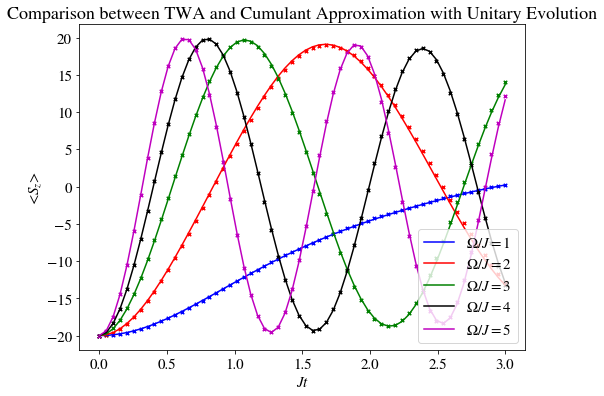

In [258]:
plt.title("Comparison between TWA and Cumulant Approximation with Unitary Evolution")

plt.xlabel("$Jt$")
plt.ylabel("<$S_z$>")


plt.scatter(t,np.real(twaomega1uni),color="b",marker='x',s=12)
plt.plot(t,np.real(cumulomega1uni),"b",label="$\Omega/J=1$ ")

plt.scatter(t,np.real(twaomega2uni),color="r",marker='x',s=12)
plt.plot(t,np.real(cumulomega2uni),label="$\Omega/J=2$ ",color="r")

plt.scatter(t,np.real(twaomega3uni),color="g",marker='x',s=12)
plt.plot(t,np.real(cumulomega3uni),label="$\Omega/J=3$ ",color="g")

plt.scatter(t,np.real(twaomega4uni),color="k",marker='x',s=12)
plt.plot(t,np.real(cumulomega4uni),label="$\Omega/J=4$ ",color="k")

plt.scatter(t,np.real(twaomega5uni),color="m",marker='x',s=12)
plt.plot(t,np.real(cumulomega5uni),label="$\Omega/J=5$ ",color="m")
plt.legend(loc="lower right");


#This is for all-to-all interactions
#Gamma/J=0.2-----> There is dephasing, non-unitary evolution

